In [3]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import warnings
from wordcloud import WordCloud
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import  PorterStemmer 
import string
import re
import warnings
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pickle 
warnings.simplefilter("ignore")
#lOADING DATASET 
df = pd.read_csv("Book_1_50.csv",encoding="latin1") #due to special charas should be encoded as latin 1
#REMOVE MAX
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
df["verified"].value_counts().to_frame()

,verified
True,30052
False,13096


### Visualize Verified

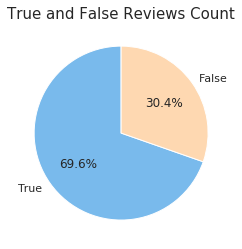

In [5]:
colors = ['#79BAEC','#FED8B1']
plt.figure(figsize=(4,4))
label = df['verified'].value_counts()
plt.pie(label.values,colors = colors, labels=label.index, autopct= '%1.1f%%', startangle=90)
plt.title('True and False Reviews Count', fontsize=15)
plt.show()

Text(0.5, 1, 'Review_Rating Grouped by Verified_Purchase')

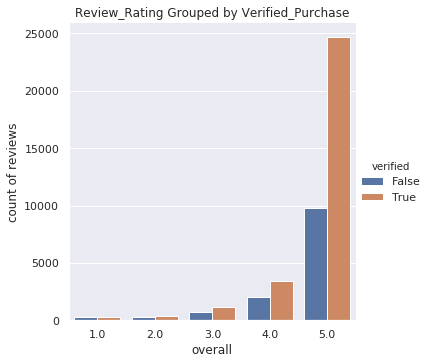

In [6]:
#COUNTPLOT OF REVIEW RATING GROUPED BY VERIFIED PURCHASE
sns.catplot(x ='overall',kind="count", hue="verified",
            data=df)
plt.xlabel("overall")
plt.ylabel("count of reviews")
plt.title("Review_Rating Grouped by Verified_Purchase")

In [12]:
#DROP USELESS COLUMNS
print(df.columns)
df.drop(['unixReviewTime'], axis=1, inplace=True)

df = df.drop_duplicates().reset_index(drop=True)

Index(['overall', 'verified', 'reviewerID', 'asin', 'reviewText', 'summary',
       'unixReviewTime', 'vote', 'image'],
      dtype='object')


In [13]:
# Word
# Characters (with spaces)
# Stopwords
# Punctuations
# Uppercase characters

import string
from nltk.corpus import stopwords

# Ensure that nltk resources are downloaded
nltk.download('stopwords')

# Your DataFrame (df) needs to be defined prior to this
# Ensure 'reviewText' is string, handle NaN values
df['reviewText'] = df['reviewText'].fillna('')

# WORD COUNT
df['total words'] = df['reviewText'].apply(lambda i: len(i.split()))

# CHARACTER COUNT
# No change needed as .str.len() handles NaN and None values as length 0
df['total characters'] = df['reviewText'].str.len()

# STOPWORDS COUNT
sw = set(stopwords.words('english'))
df['total stopwords'] = df['reviewText'].apply(lambda x: len([word for word in x.lower().split() if word in sw]))

# PUNCTUATION AND SPECIAL CHARA COUNT
# Ensure you have imported string or have a list of punctuation characters
count_p = lambda p1, p2: sum([1 for i in p1 if i in p2])
df['total punctuations'] = df['reviewText'].apply(lambda p: count_p(p, string.punctuation))

# UPPERCASE CHARA COUNT
df['total uppercases'] = df['reviewText'].apply(lambda x: len([c for c in x if c.isupper()]))


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/li.wany/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
#CORRECT SPELLING
df.reviewText.apply(lambda i: ''.join(TextBlob(i).correct()))
#REMOVING THE STOPWORDS,PUNCTUATIONS, LOWERCASING, AND STEMMING OF THE SENTENCES
def text_preprocessing(text):
    removed_special_characters = re.sub("[^a-zA-Z]", " ", str(text))
    tokens = removed_special_characters.lower().split()
    
    stemmer = PorterStemmer()
    cleaned = []
    stemmed = []
    
    for token in tokens:
        if token not in sw:
            cleaned.append(token)
            
    for token in cleaned:
        token = stemmer.stem(token)
        stemmed.append(token)

    return " ".join(stemmed)
df['reviewText'] = df['reviewText'].apply(text_preprocessing)

In [15]:
#CHECK RARE WORDS
r = pd.Series(' '.join(df['reviewText']).split()).value_counts()[-10:]
print("RARE WORDS:")
print(r)

RARE WORDS:
beowolf        1
unspool        1
jugular        1
istic          1
pranksuntil    1
anywaay        1
imaginit       1
instalov       1
authorjx       1
raspberri      1
dtype: int64


In [ ]:
#removing common and rare words
common = pd.Series(' '.join(df['reviewText']).split()).value_counts()[:3]
common = list(common.index)
df['reviewText'] = df['reviewText'].apply(lambda i: " ".join(i for i in i.split() if i not in common))

rare = pd.Series(' '.join(df['reviewText']).split()).value_counts()[-3:]
rare = list(rare.index)
df['reviewText'] = df['reviewText'].apply(lambda i: " ".join(i for i in i.split() if i not in rare))

In [ ]:
#WORDCLOUD - UPDATED TOP WORDS
words = '' 
for i in df["reviewText"]: 
    tokens = i.split()   
    words += " ".join(tokens)+" "

    
word_cloud = WordCloud(width = 700, height = 700, background_color ='white', min_font_size = 10).generate(words) 
plt.figure(figsize = (5, 5)) 
plt.imshow(word_cloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

In [ ]:
df['reviewText'].apply(word_tokenize).head()

In [ ]:
df.to_csv('processedData50.csv')

In [18]:
checkNULL = df.isnull()
checkNULL = checkNULL.any(axis=1)

In [19]:
#DROP THE NULL ROWS
df = df.dropna(subset=['reviewText'])
print(len(df))

42646


In [20]:
#UPDATED VP VALUES 
df["verified"].value_counts(normalize=True)

True     0.693289
False    0.306711
Name: verified, dtype: float64

In [21]:
#ASSIGN THE VARIABLES
X = df['reviewText'] #input var
y = df['verified'] #target var

In [22]:
#SPLIT DATA
X_train, X_test, y_train, y_test = train_test_split(
    df['reviewText'], df['verified'],test_size=0.4, random_state=42) #40% gives best results, 42 is no of life...

entiredf = format(df.shape[0])
traindf = format(X_train.shape[0])
testdf = format(X_test.shape[0])


In [24]:
count_vectorizer  = CountVectorizer(stop_words='english')
count_vectorizer.fit(X_train)
train_c = count_vectorizer.fit_transform(X_train)
test_c = count_vectorizer.transform(X_test)

### Multinomial Naive Bayes model

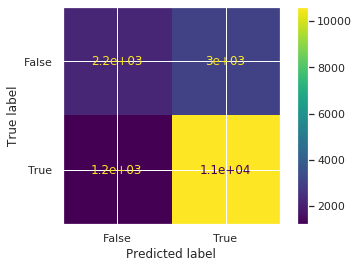

In [25]:
#IMPLEMENTING AND RUNNNING MNB MODEL - COUNT
mnb1 = MultinomialNB()
mnb1.fit(train_c, y_train)
prediction = mnb1.predict(test_c)
#EVALUATION
mnb_a1 = accuracy_score(y_test, prediction)*100
mnb_p1 = precision_score(y_test, prediction)* 100
mnb_r1 = recall_score(y_test, prediction)*100
mnb_f11 = f1_score(y_test, prediction)*100
#CONFUSION MATRIX
cm =  confusion_matrix(y_test, prediction, labels=mnb1.classes_)
display = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=mnb1.classes_) 
display.plot() 

### Support Vector Machine model

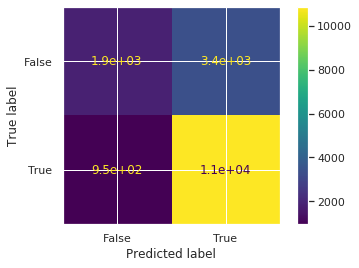

In [26]:
#IMPLEMENTING AND RUNNNING SVM MODEL - COUNT
svm1 = SVC(kernel='linear')
svm1.fit(train_c, y_train)
prediction = svm1.predict(test_c)
#EVALUATION
svm_a1 = accuracy_score(y_test, prediction)*100
svm_p1 = precision_score(y_test, prediction)* 100
svm_r1 = recall_score(y_test, prediction)*100
svm_f11 = f1_score(y_test, prediction)*100
#CONFUSION MATRIX
cm =  confusion_matrix(y_test, prediction, labels=svm1.classes_)
display = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=svm1.classes_) 
display.plot() 

### Logistic Regression model

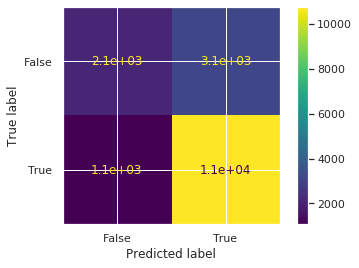

In [27]:
#IMPLEMENTING AND RUNNNING LR MODEL - COUNT
lr1 = LogisticRegression()
lr1.fit(train_c, y_train)
prediction = lr1.predict(test_c)
#EVALUATION
lr_a1 = accuracy_score(y_test, prediction)*100
lr_p1 = precision_score(y_test, prediction)* 100
lr_r1 = recall_score(y_test, prediction)*100
lr_f11 = f1_score(y_test, prediction)*100
#CONFUSION MATRIX
cm =  confusion_matrix(y_test, prediction, labels=lr1.classes_)
display = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=lr1.classes_) 
display.plot() 

In [28]:
### COMPARING ACCURACY

In [34]:
model_accuracy={'MNB': [round(mnb_a1)],
                'SVM': [round(svm_a1)],
                'LR': [round(lr_a1)]
               }
ma = pd.DataFrame(model_accuracy, columns = ['MNB','SVM','LR'], index=['Count Vectorizer'])
ma

,MNB,SVM,LR
Count Vectorizer,75.0,75.0,75.0


In [31]:
### COMPARING F1 score

In [35]:
model_f1={'MNB': [round(mnb_f11)],
                'SVM': [round(svm_f11)],
                'LR': [round(lr_f11)]
               }
mf1 = pd.DataFrame(model_f1, columns = ['MNB','SVM','LR'], index=['Count Vectorizer'])
mf1

,MNB,SVM,LR
Count Vectorizer,83.0,83.0,84.0
